# IMDB - Sentiment Analysis of movie reviews

**Objective**: build a sentiment-analysis model of movie reviews predicting if a given review is negative or positive.

**Dataset**: [https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset](https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset)

---

## Introduction

In this notebook, we see how to perform sentiment analysis using the IMDB Movie Reviews Dataset. We will classify reviews into *positives* (label 1) and *negetives* (label 0). We will encode the data using tf to feed a Logistic Regression Model.


This notebook follows the [Text Classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Machine Learning Guides.

---

## Notebook Preface


Let's start by loading PySpark and by building a SparkContext.

In [1]:
# import spark
from pyspark import SparkContext
# initialize a new Spark Context to use for the execution of the script
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
# prevent useless logging messages
sc.setLogLevel("ERROR")

Load all other required modules.

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.feature import HashingTF, StandardScaler
from pyspark.mllib.feature import LabeledPoint

Define all constants and variables that we will be used throughout the entire notebook.

In [4]:
DATASET_PATH = "hdfs://masterbig-1.itc.unipi.it:54310/masterbig_data/aclImdb/"
DEVELOPMENT_ENABLED = "MEDIUM"

---

## Step 1: Data Gathering

Let's load the dataset. We just load a subset of the dataset during the development.

**Note**: data are stored within HDFS.

In [5]:
if DEVELOPMENT_ENABLED == "BIG":
    pos_filter, neg_filter = "_10", "_1"
elif DEVELOPMENT_ENABLED == "MEDIUM":
    pos_filter, neg_filter = "1_10", "1_1"
elif DEVELOPMENT_ENABLED == "SMALL":
    pos_filter, neg_filter = "01_10", "01_1"
else:
    assert DEVELOPMENT_ENABLED is False
    pos_filter, neg_filter = "", ""

train_path = "{0}train/pos/*{1}.txt,{0}train/neg/*{2}.txt".format(DATASET_PATH, pos_filter, neg_filter)
test_path = "{0}test/pos/*{1}.txt,{0}test/neg/*{2}.txt".format(DATASET_PATH, pos_filter, neg_filter)

train_raw_rdd = sc.wholeTextFiles(train_path, use_unicode=True)
test_raw_rdd = sc.wholeTextFiles(test_path, use_unicode=True)

Check the rdd content.

In [6]:
train_raw_rdd.takeSample(withReplacement=False, num=2, seed=9)

[('hdfs://masterbig-1.itc.unipi.it:54310/masterbig_data/aclImdb/train/neg/8591_1.txt',
  "I'm trying to decide if jumping into a wood chopper would be more enjoyable than this dreck. It finishes the destruction of what was once a classic couple of films. With Jedi, Menace, Clowns and Sith we have the death of Lucas' career. He wants us to swallow the Annakin is Vader nonsense? I never believed it was true. This film vindicates those feelings. The story hasn't worked since Phantom Moron, and each new film just piled the crap on until all that was left was a toy parade. I have to go. I know where some new rocks to throw are. You want spoilers? Here they come. Luke and Leia are NOT related. Vader is NOT their Father. Duke Countoo should have switched sides while he still could. Yoda has less verbal skills than Yogi Berra. His advice has never been any good to anybody. Obi Wan lied to Luke for the first two films. Annakin didn't build C3P0. He found him in the desert and lied to his Mom ab

Clean the text and retrieve the rating from the filename.

In [7]:
text_pattern = re.compile('[^a-z ]+')
text_pattern2 = re.compile('[ ]+')
def transform_filename_text_pair(pair):
    filename, text = pair
    rating = int(filename[filename.rfind("_")+1:filename.rfind(".")])
    cleaned_text = text_pattern2.sub(
        ' ',
        text_pattern.sub(
            ' ',
            text.lower()
        )
    )
    return (rating, cleaned_text)

train_clean_rdd = train_raw_rdd.map(transform_filename_text_pair)
test_clean_rdd = test_raw_rdd.map(transform_filename_text_pair)

Check the content of the cleaned rdd. 

In [8]:
train_clean_rdd.takeSample(withReplacement=False, num=2, seed=9)

[(1,
  'i m trying to decide if jumping into a wood chopper would be more enjoyable than this dreck it finishes the destruction of what was once a classic couple of films with jedi menace clowns and sith we have the death of lucas career he wants us to swallow the annakin is vader nonsense i never believed it was true this film vindicates those feelings the story hasn t worked since phantom moron and each new film just piled the crap on until all that was left was a toy parade i have to go i know where some new rocks to throw are you want spoilers here they come luke and leia are not related vader is not their father duke countoo should have switched sides while he still could yoda has less verbal skills than yogi berra his advice has never been any good to anybody obi wan lied to luke for the first two films annakin didn t build c p he found him in the desert and lied to his mom about putting him together from scratch chewbacca has fleas this whole mess with vader and the fall of the 

---

## Step 2: Data Exploration

Verify the number of examples and the number of samples in each class.

In [9]:
pd.DataFrame(
    data=[train_raw_rdd.count(), test_raw_rdd.count()],
    index=["train", "test"],
    columns=["num examples"]
)

,num examples
train,981
test,1000


In [10]:
def count_labels(raw_rdd):
    return dict(
        raw_rdd
            .map(lambda pair: ("pos" if pair[0] > 5 else "neg", 1))
            .reduceByKey(lambda l, r: l + r)
            .collect()
    )

pd.DataFrame(
    data=[count_labels(train_clean_rdd), count_labels(test_clean_rdd)],
    index=["train", "test"]
)

,neg,pos
train,505,476
test,509,491


Compute the average number of words per sample.

**Note**: From now on we must "explore" only the training set!

In [11]:
length_distribution = dict(
    train_clean_rdd
        .map(lambda pair: (
            len(pair[1].split()),
            np.array([0, 1] if pair[0] > 5 else [1, 0])
        ))
        .reduceByKey(lambda l, r: l+r)
        .collect()
)

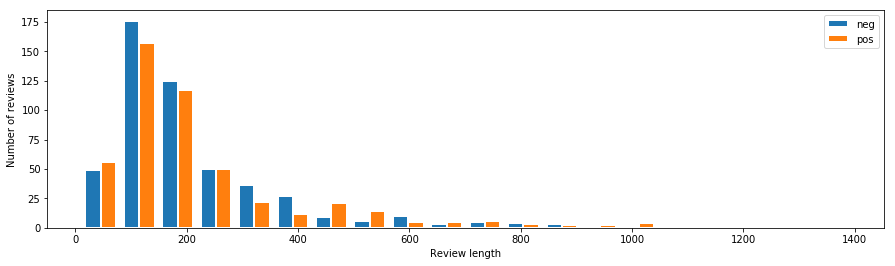

In [12]:
plt.figure(figsize=(15,4))
plt.hist(
    x=np.array([(l, l) for l in length_distribution.keys()]),
    weights=np.array(list(length_distribution.values())),
    histtype='bar', stacked=False,
    label=["neg", "pos"],
    bins=20, density=False,
    edgecolor='white', linewidth=2
)
plt.xlabel("Review length")
plt.ylabel("Number of reviews")
plt.legend(loc="upper right")
plt.show()

Compute the most seen words in the corpus

In [13]:
most_frequent_words = [
    tpl
    for _, tpl in train_clean_rdd
        .flatMap(lambda pair: [
            (word, np.array([0, 1, 1] if pair[0] > 5 else [1, 0, 1]))
            for word in set(pair[1].split())
        ])
        .reduceByKey(lambda l, r: l+r)
        .map(lambda tpl: (tpl[1][-1], tpl))
        .top(100)
]

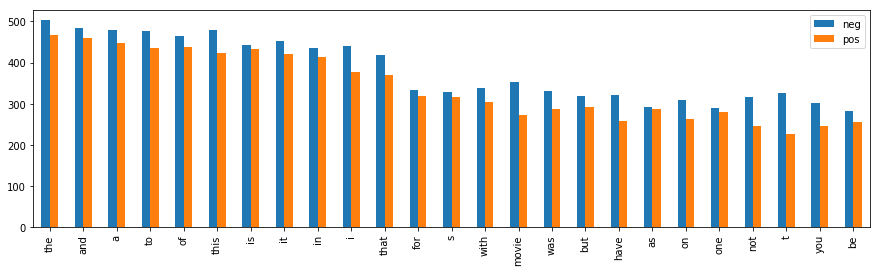

In [14]:
how_many = 25

pd.DataFrame(
    data=[
        counts[:2]
        for k, counts in most_frequent_words[:how_many]
    ],
    index=[
        k
        for k, counts in most_frequent_words[:how_many]
    ],
    columns=["neg", "pos"]
).plot.bar(figsize=(15, 4))
plt.show()

The most frequency words are stop words. We will discard them in our analysis.

In [15]:
stopword_set = set(
    k
    for k, counts in most_frequent_words[:20]
)

---

## Step 3: Data Preparation

Remove the stopwords and Vectorize the remaining words. Lastly, create the LabeledPoints.

In [16]:
tf_transformer = HashingTF(numFeatures=1000)

In [17]:
def transform(rdd):
    return rdd\
        .mapValues(lambda text: [w for w in text.split() if w not in stopword_set])\
        .mapValues(lambda words: tf_transformer.transform(words))\
        .map(lambda pair: LabeledPoint(1 if pair[0] > 5 else 0, pair[1]))

train_rdd = transform(train_clean_rdd)
test_rdd = transform(test_clean_rdd)

---

## Step 4: Training and Assessment

In [18]:
model = LogisticRegressionWithLBFGS.train(train_rdd)

Print some reviews and the predicted sentiments.

In [19]:
def transform(pair):
    filename, text = pair
    rating, cleaned_text = transform_filename_text_pair(pair)

    words = [w for w in cleaned_text.split() if w not in stopword_set]
    pred = model.predict(tf_transformer.transform(words))
    return (text, pred, rating)

model.clearThreshold()
data = test_raw_rdd\
    .filter(lambda pair: len(pair[1]) < 500)\
    .map(transform)\
    .takeSample(withReplacement=False, num=10, seed=9)
model.setThreshold(0.5)

In [20]:
for text, pred, rating in data:
    print("Rating {}\tProbability {:.3f}\n{}\n".format(rating, pred, text))

Rating 10	Probability 1.000
A wonder. My favorite film. The most important film about relationships ever made. Brilliant writing. Magnificent directing. Image systems and symbolism that leave you thinking about it all days, weeks, years later. Wow. A truly great work of art.

Rating 10	Probability 0.993
This is one of the great movies of all time. The story is fascinating and the actors are convincing. Your really identify with the characters. William Wyler proofs with this movie that he is a great director. His craftsmanship is unsurpassed.

Rating 10	Probability 0.000
Critters 4: This movie was continued after the 3rd critters movies. This one was released in the same years as critters 3 was released in 1991. Critters 4 takes you in space as they hunt for the humans in a space ship. I doubt if there will be a Critters 5 because the ending for the 4th was quite a good ending, which brought the end to the critters as there was no more left. I give this movie 10 out of 10.

Rating 1	Pro

Performance assessment.

In [21]:
def confusion_matrix(labels, predictions):
    counts_rdd = predictions.zip(labels).map(lambda k: (k,1)).reduceByKey(lambda l,r: l+r)
    counts = dict(((i,j),0) for i in [0,1] for j in [0,1])  # set to 0 all the entries
    counts.update( dict(counts_rdd.collect()) )  # update the non-0 entries
    confusion_matrix = [
        [
            counts[(pred,act)]
            for act in [0,1]
        ] for pred in [0,1]
    ]
    df_cm = pd.DataFrame(confusion_matrix, index = ["Pred 0", "Pred 1"], columns = ["Act 0", "Act 1"])
    sns.heatmap(df_cm, annot=True, fmt='', annot_kws={"size": 14})
    return confusion_matrix

In [22]:
test_labels = test_rdd.map(lambda lp: lp.label)
test_predictions = test_rdd.map(lambda lp: model.predict(lp.features))

[[436, 116], [73, 375]]

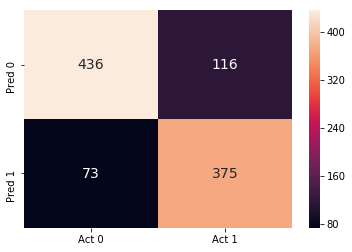

In [23]:
confusion_matrix(test_labels, test_predictions)

In [24]:
accuracy = test_labels\
    .zip(test_predictions)\
    .map(lambda pair: 1.0 if (pair[0] == pair[1]) else 0.0)\
    .reduce(lambda l, r: l+r) / test_predictions.count()
print("Accuracy", accuracy)

Accuracy 0.811


---

## Step 5: Hyperparameters tuning

The above model is not tuned. So, take your time to find the best set of hyperparameters!

# Close the SparkContext to free the resources

In [25]:
sc.stop()